In [1]:
import sys
sys.path.append("..")

import andi
from graphtrack import deeptrack as dt

import numpy as np

from xml.dom import minidom
import os
from datetime import date

c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\graphtrack\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\graphtrack\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [2]:
"""max_x = 0
max_y = 0"""
def ProcessDataset(scale_traj, shift_traj, seq_length = 10, **kwargs):
    def inner(data):
        trajectories = []
        trajs = np.array(data)[:, 2:]
        
        # scale, shift, strip
        for traj in trajs:
            traj[:seq_length] = (
                scale_traj * (traj[:seq_length])
                + np.random.rand(1) * shift_traj
            )

            traj[seq_length:] = (
                scale_traj * (traj[seq_length:])
                + np.random.rand(1) * shift_traj
            )

            trajectories.append(
                np.transpose([traj[:seq_length], traj[seq_length:]])
            )
        return trajectories
    return inner

def to_xml(mean_intensities, std_intensity, **kwargs): # , mean_radii, std_radius
    def inner(data):

        root = minidom.Document()
        xml = root.createElement("root")
        root.appendChild(xml)

        data = dataset.update().resolve() 

        description = root.createElement("GlobalHeterogenousInfo")
        description.attributes["scenario"] = "Heterogeneous alpha"
        #description.attributes["global_prop"] = str(data[0].get_property("percentage_alpha"))
        description.attributes["total_particles"] = str(np.sum(data[0].get_property("N")))
        description.attributes["sequence_length"] = str(data[0].get_property("seq_length"))
        description.attributes["model"] = str(data[0].get_property("model"))
        description.attributes["generationDateTime"] = str(date.today())
        xml.appendChild(description)
        
    
        alphas = data[0].get_property("alpha")
        for idx, (traj, mean_intensity) in enumerate(zip(data, mean_intensities)): #, mean_radius # , mean_radii
            particle = root.createElement("particle")
            description.appendChild(particle)

            traj = np.array(traj)
            intensities = np.random.normal(mean_intensity, std_intensity, len(traj))
            #radii = np.random.normal(mean_radius, std_radius, len(traj))
            for frame, [coord, intensity] in enumerate(zip(traj, intensities)): # , radius # , radii
                point = root.createElement("detection")
                point.attributes["frame"] = str(frame)
                point.attributes["x"] = str(coord[0])
                point.attributes["y"] = str(coord[1])
                point.attributes["intensity"] = str(intensity)
                #point.attributes["radius"] = str(radius)
                point.attributes["solution"] = str(alphas[idx])
                
                particle.appendChild(point)
    
        return root
    return inner


import numpy as np

def generate_fix_sum_random_vec(limit, num_elem, tries=10):
    v = np.random.randint(0, limit, num_elem)
    s = sum(v)
    if (np.sum(np.round(v/s*limit)) == limit):
        return np.round(v / s * limit)
    elif (np.sum(np.floor(v/s*limit)) == limit):
        return np.floor(v / s * limit)
    elif (np.sum(np.ceil(v/s*limit)) == limit):
        return np.ceil(v / s * limit)
    else:
        return generate_fix_sum_random_vec(limit, num_elem, tries-1)

In [30]:
import random

def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)
    
root = dt.DummyFeature(
    seq_length=lambda: np.random.randint(25, 30),
    N = lambda total_n_of_particles: np.ones((1, total_n_of_particles)).astype(int),
    total_n_of_particles=lambda: np.random.randint(50, 60),
    alpha = lambda total_n_of_particles: random.sample(list(np.round(0.2+1.2*np.random.rand(200),2)), total_n_of_particles),#random.sample(list(np.round(np.linspace(0.20, 1.80, 200),2)),total_n_of_particles)
    model=2, 
) 

dataset = root >> dt.Value(
    value = lambda seq_length, N, alpha, model: andi.andi_datasets().create_dataset(
            T=seq_length, N=N, exponents=alpha, models=model, dimension=2),
    **root.properties
) >> dt.Lambda(ProcessDataset,
    scale_traj=lambda: np.random.uniform(10, 15),
    shift_traj=30, 
     **root.properties
 ) 

In [31]:
np.shape(np.array(dataset.resolve()))

(58, 25, 2)

In [32]:

 
xml_loader = dataset >> dt.Lambda(
     to_xml, 
    mean_intensities = lambda min_intensity, max_intensity, N: np.random.choice(
         np.arange(
             min_intensity, 
             max_intensity
             ), 
         size=np.sum(N)
     ),
     min_intensity = 60, 
     max_intensity = 95,
     std_intensity = 3,
    
     
     **root.properties)

"""mean_radii = lambda min_radius, max_radius, N: np.random.choice(
         np.arange(
             min_radius, 
             max_radius
             ), 
         size=np.sum(N)
     ),
     min_radius = 2, 
     max_radius = 3, 
     std_radius = .3,"""

'mean_radii = lambda min_radius, max_radius, N: np.random.choice(\n         np.arange(\n             min_radius, \n             max_radius\n             ), \n         size=np.sum(N)\n     ),\n     min_radius = 2, \n     max_radius = 3, \n     std_radius = .3,'

In [34]:
mode = ["training","testing"]
os.makedirs("xml-generators1/xml_data/mixed_alpha_nodes/"+mode[0], exist_ok=True)
os.makedirs("xml-generators1/xml_data/mixed_alpha_nodes/"+mode[1], exist_ok=True)

In [35]:
_SAMPLES_ = [5, 5] #[Training, Testing]

for i in range(len(_SAMPLES_)):
    for sample in range(_SAMPLES_[i]):
        xml = xml_loader.update().resolve()
        with open("xml-generators1/xml_data/mixed_alpha_nodes/"+mode[i]+"/sample_"+str(sample+1)+".xml", "w") as f:
            f.write(xml.toprettyxml(indent ="\t"))

In [36]:
import untangle

path  = "./xml-generators1/xml_data/mixed_alpha_nodes/training/sample_2.xml"
xml = untangle.parse(path)

In [37]:
particles = xml.root.GlobalHeterogenousInfo.particle

detection_list = []
for p in range(len(particles)):
    detections = particles[p].detection
    for d in range(len(detections)):
        detection_att = {
            "frame": int(detections[d]["frame"]),
            "centroid_x": float(detections[d]["x"]),
            "centroid_y": float(detections[d]["y"]),
            #"intensity": float(detections[d]["intensity"]),
            "label": int(p + 1),
            "solution": float(detections[d]["solution"])
            }
        detection_list.append(detection_att)

In [38]:
import pandas as pd
df = (
    pd.DataFrame.from_dict(detection_list)
    .sort_values(by=["frame"])
    .reset_index(drop=True)
)

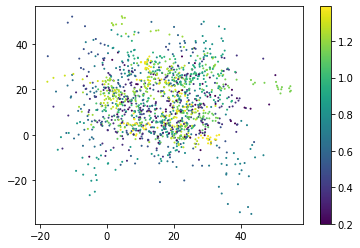

In [39]:
x = df["centroid_x"].values
y = df["centroid_y"].values
z = df["solution"].values

import matplotlib.pyplot as plt

plt.scatter(x, y, c=z, s=1)
plt.colorbar()